# Image Classification

https://www.kaggle.com/competitions/journey-springfield

Team name: Andrey_Sologub_656031368

### Dependency installation

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/"Colab Notebooks"/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 23 12:05:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# define directories with training and test files
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

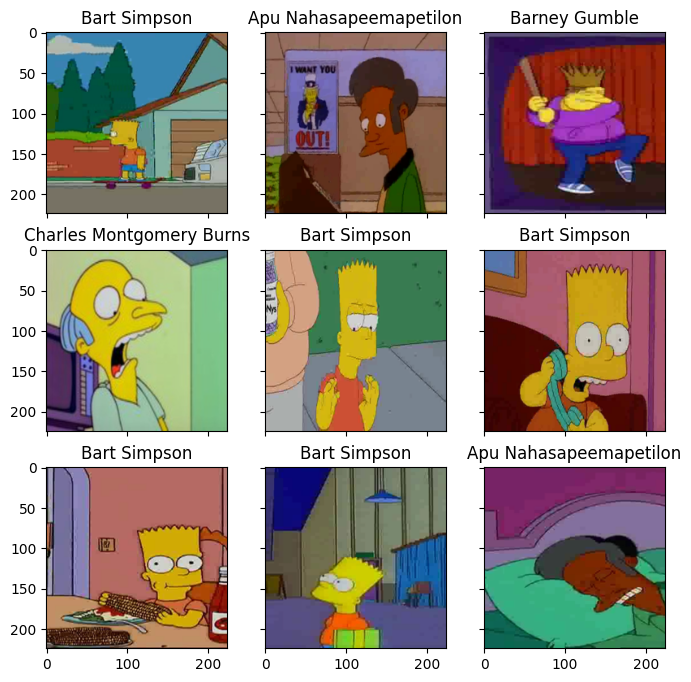

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Building a neural network

*Layer description*:

1. input dimension: 3x224x224
2. post layer dimensions: 8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. output: 96x5x5

In [ ]:


class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.747982132669482


epoch:  12%|█▎        | 1/8 [01:46<12:25, 106.52s/it]


Epoch 001 train_loss: 1.7480     val_loss 1.4320 train_acc 0.5315 val_acc 0.6123
loss 1.0456750505448482


epoch:  25%|██▌       | 2/8 [03:32<10:37, 106.21s/it]


Epoch 002 train_loss: 1.0457     val_loss 0.9017 train_acc 0.7117 val_acc 0.7501
loss 0.6690404405164235


epoch:  38%|███▊      | 3/8 [05:21<08:56, 107.40s/it]


Epoch 003 train_loss: 0.6690     val_loss 0.8565 train_acc 0.8103 val_acc 0.7661
loss 0.45895594625258435


epoch:  50%|█████     | 4/8 [07:10<07:11, 107.91s/it]


Epoch 004 train_loss: 0.4590     val_loss 0.7341 train_acc 0.8675 val_acc 0.8170
loss 0.30449961643627826


epoch:  62%|██████▎   | 5/8 [08:56<05:21, 107.27s/it]


Epoch 005 train_loss: 0.3045     val_loss 0.7753 train_acc 0.9078 val_acc 0.8137
loss 0.22463010959562144


epoch:  75%|███████▌  | 6/8 [10:42<03:34, 107.06s/it]


Epoch 006 train_loss: 0.2246     val_loss 0.8323 train_acc 0.9287 val_acc 0.8216
loss 0.15915974715506395


epoch:  88%|████████▊ | 7/8 [12:25<01:45, 105.74s/it]


Epoch 007 train_loss: 0.1592     val_loss 0.9164 train_acc 0.9513 val_acc 0.8267
loss 0.12809036670691556


epoch: 100%|██████████| 8/8 [14:09<00:00, 106.23s/it]


Epoch 008 train_loss: 0.1281     val_loss 0.8991 train_acc 0.9586 val_acc 0.8298


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

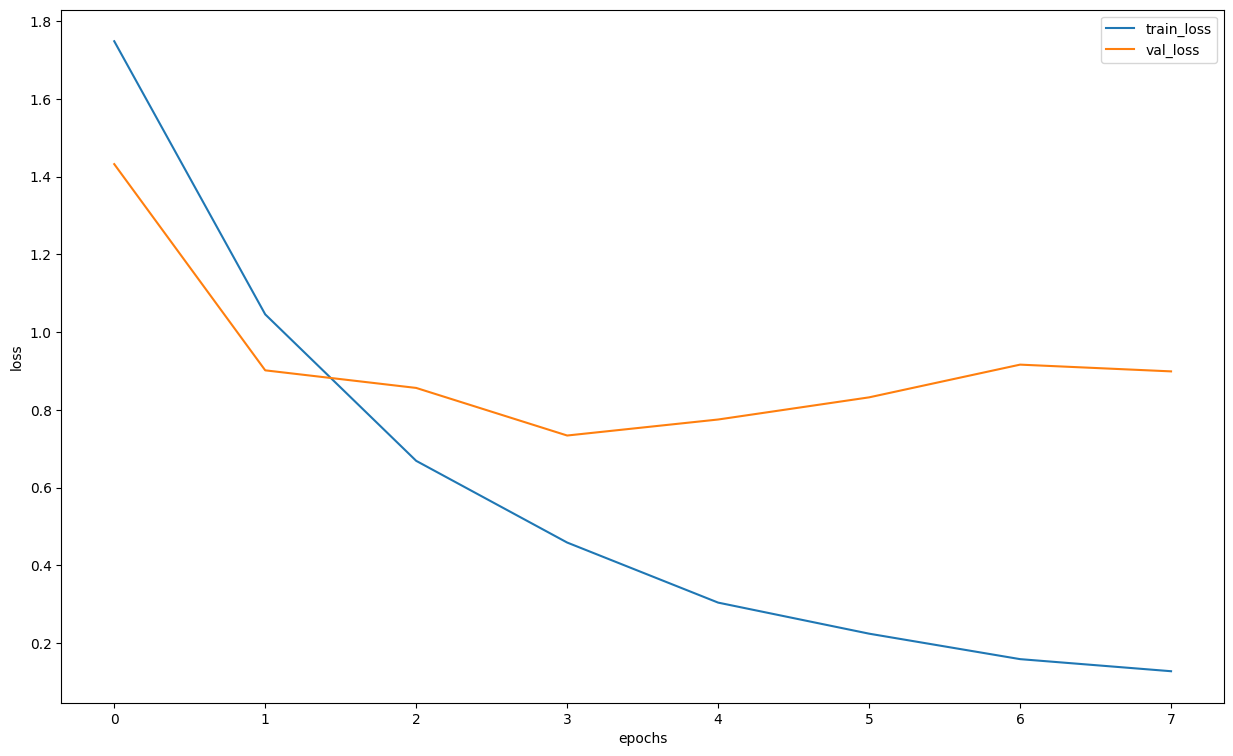

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)


F1-оценка: 0.75


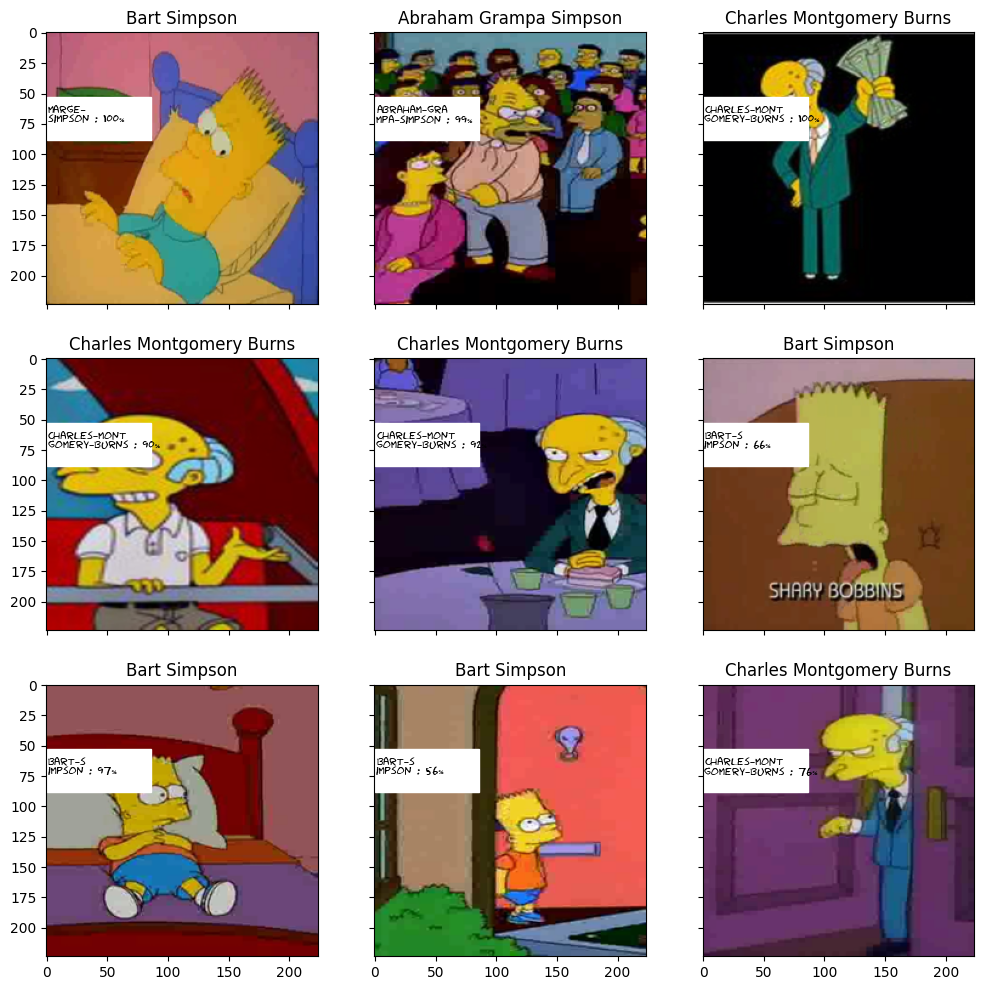

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

### AlexNet

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torchvision import models
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
model.classifier = nn.Linear(9216, n_classes)
model_alexnet = model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_alexnet, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.9159696340557117


epoch:  12%|█▎        | 1/8 [01:43<12:05, 103.67s/it]


Epoch 001 train_loss: 1.9160     val_loss 1.0241 train_acc 0.4832 val_acc 0.7365
loss 0.8510372094708921


epoch:  25%|██▌       | 2/8 [03:28<10:25, 104.18s/it]


Epoch 002 train_loss: 0.8510     val_loss 0.7653 train_acc 0.7743 val_acc 0.7940
loss 0.5670413996802902


epoch:  38%|███▊      | 3/8 [05:11<08:39, 103.97s/it]


Epoch 003 train_loss: 0.5670     val_loss 0.6934 train_acc 0.8432 val_acc 0.8240
loss 0.4380309676067018


epoch:  50%|█████     | 4/8 [06:56<06:56, 104.13s/it]


Epoch 004 train_loss: 0.4380     val_loss 0.7660 train_acc 0.8762 val_acc 0.8128
loss 0.36353170217940123


epoch:  62%|██████▎   | 5/8 [08:40<05:12, 104.11s/it]


Epoch 005 train_loss: 0.3635     val_loss 0.8658 train_acc 0.8959 val_acc 0.8244
loss 0.2751771997506394


epoch:  75%|███████▌  | 6/8 [10:23<03:27, 103.88s/it]


Epoch 006 train_loss: 0.2752     val_loss 0.7034 train_acc 0.9215 val_acc 0.8538
loss 0.24926287014967805


epoch:  88%|████████▊ | 7/8 [12:06<01:43, 103.54s/it]


Epoch 007 train_loss: 0.2493     val_loss 0.8571 train_acc 0.9271 val_acc 0.8323
loss 0.29870477408852686


epoch: 100%|██████████| 8/8 [13:49<00:00, 103.65s/it]


Epoch 008 train_loss: 0.2987     val_loss 0.9377 train_acc 0.9163 val_acc 0.8120


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

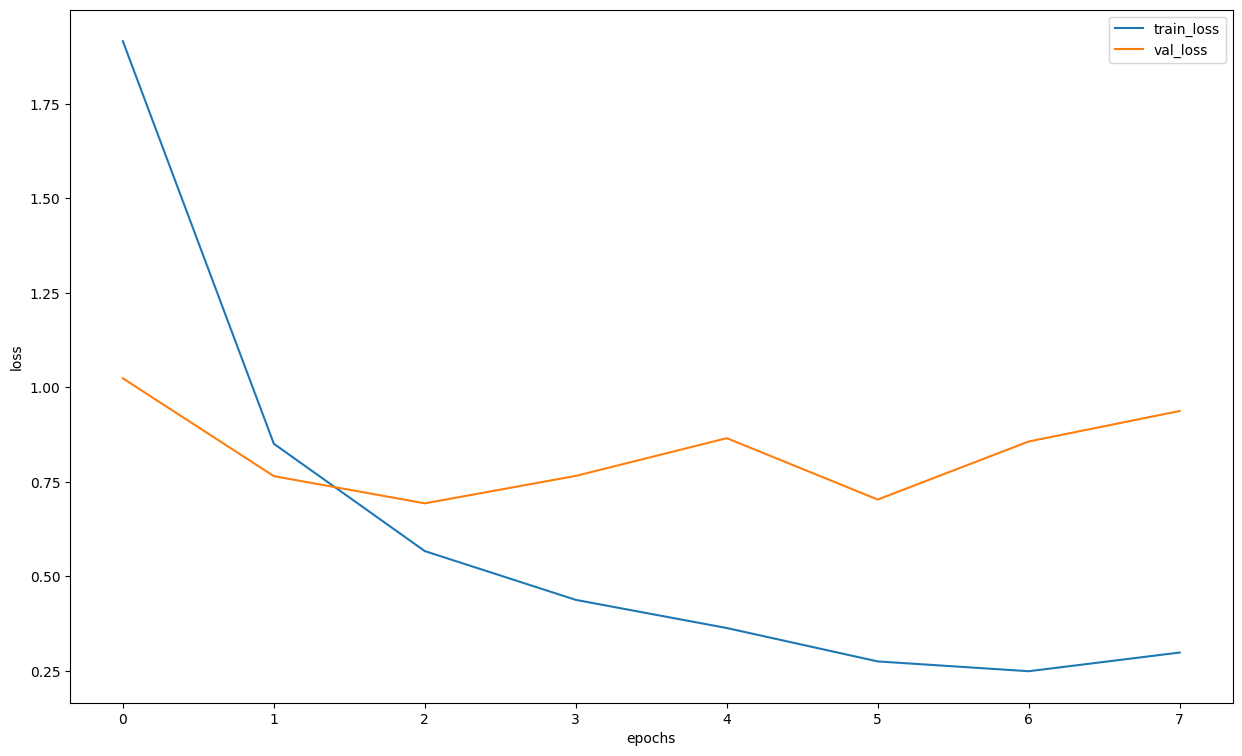

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_alexnet, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_alexnet, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.7


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_alexnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('AlexNet_baseline.csv', index=False)


### AlexNet (Feature Extractor)

In [ ]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(9216, n_classes)

In [ ]:
model_alexnet_extractor = model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_alexnet_extractor, epochs=6, batch_size=64)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.785032961382077


epoch:  17%|█▋        | 1/6 [01:43<08:36, 103.20s/it]


Epoch 001 train_loss: 1.7850     val_loss 1.2803 train_acc 0.6526 val_acc 0.7614
loss 0.37349883751570323


epoch:  33%|███▎      | 2/6 [03:23<06:46, 101.67s/it]


Epoch 002 train_loss: 0.3735     val_loss 1.1384 train_acc 0.8964 val_acc 0.7889
loss 0.15038083203340877


epoch:  50%|█████     | 3/6 [05:05<05:04, 101.67s/it]


Epoch 003 train_loss: 0.1504     val_loss 1.2260 train_acc 0.9529 val_acc 0.7956
loss 0.07746209844323251


epoch:  67%|██████▋   | 4/6 [06:46<03:23, 101.54s/it]


Epoch 004 train_loss: 0.0775     val_loss 1.1744 train_acc 0.9767 val_acc 0.8114
loss 0.056820821455132335


epoch:  83%|████████▎ | 5/6 [08:29<01:41, 101.80s/it]


Epoch 005 train_loss: 0.0568     val_loss 1.2605 train_acc 0.9828 val_acc 0.8080
loss 0.061565757769512536


epoch: 100%|██████████| 6/6 [10:10<00:00, 101.79s/it]


Epoch 006 train_loss: 0.0616     val_loss 1.4156 train_acc 0.9831 val_acc 0.8015


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

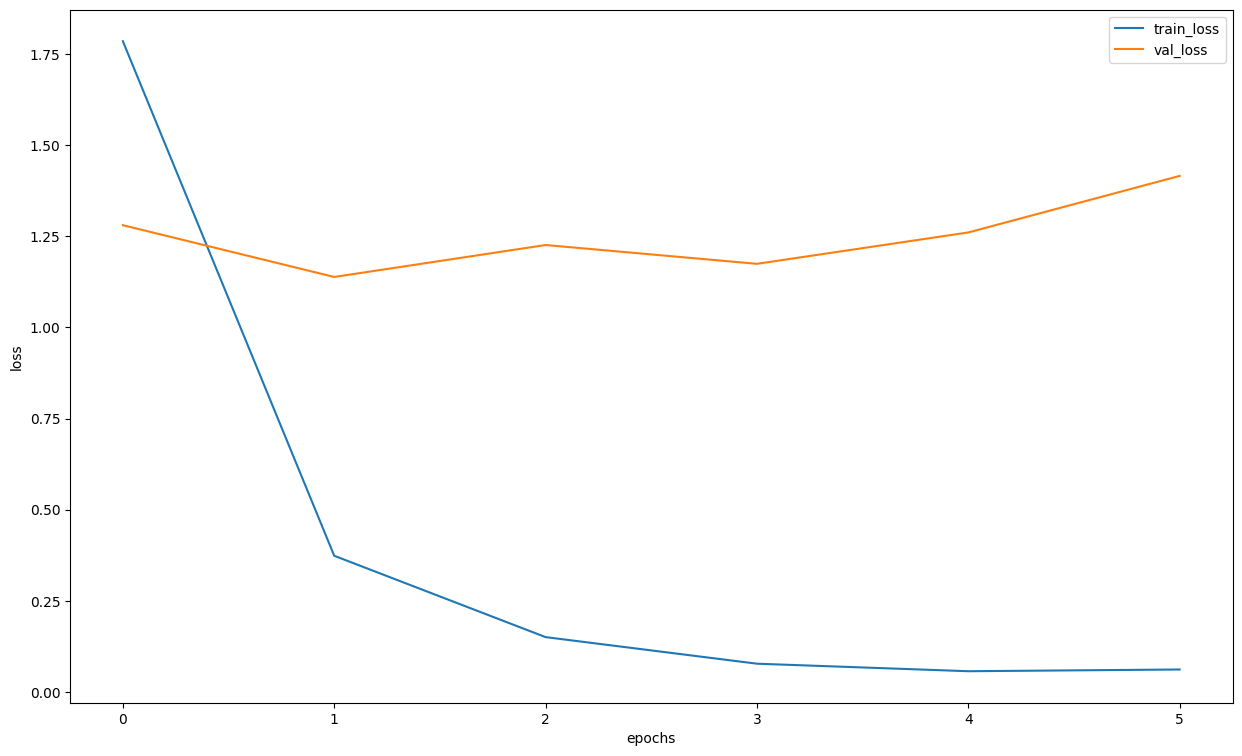

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_alexnet_extractor, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_alexnet_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.9


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_alexnet_extractor, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,barney_gumble
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('AlexNet_extractor_baseline.csv', index=False)

### Inception


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = models.inception_v3(pretrained=True)
model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.aux_logits=False
in_features = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(in_features, n_classes)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, n_classes)

In [ ]:
model.classifier = nn.Linear(25088, n_classes)
model_inception3 = model.to(DEVICE)

In [ ]:
# Scale images to size 299x299
RESCALE_SIZE = 299

In [ ]:
history = train(train_dataset, val_dataset, model=model_inception3, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.466801666622671


epoch:  10%|█         | 1/10 [02:33<23:02, 153.61s/it]


Epoch 001 train_loss: 2.4668     val_loss 1.9503 train_acc 0.3611 val_acc 0.5306
loss 1.641130702883903


epoch:  20%|██        | 2/10 [05:01<20:03, 150.41s/it]


Epoch 002 train_loss: 1.6411     val_loss 1.5423 train_acc 0.6046 val_acc 0.6133
loss 1.3078350729453


epoch:  30%|███       | 3/10 [07:30<17:27, 149.59s/it]


Epoch 003 train_loss: 1.3078     val_loss 1.3719 train_acc 0.6718 val_acc 0.6479
loss 1.112985348555683


epoch:  40%|████      | 4/10 [09:59<14:56, 149.38s/it]


Epoch 004 train_loss: 1.1130     val_loss 1.2692 train_acc 0.7169 val_acc 0.6588
loss 0.9862948906589476


epoch:  50%|█████     | 5/10 [12:31<12:31, 150.30s/it]


Epoch 005 train_loss: 0.9863     val_loss 1.1932 train_acc 0.7432 val_acc 0.6817
loss 0.8927051571875106


epoch:  60%|██████    | 6/10 [15:00<10:00, 150.02s/it]


Epoch 006 train_loss: 0.8927     val_loss 1.1567 train_acc 0.7680 val_acc 0.6930
loss 0.8117054109968527


epoch:  70%|███████   | 7/10 [17:30<07:29, 149.80s/it]


Epoch 007 train_loss: 0.8117     val_loss 1.1145 train_acc 0.7918 val_acc 0.7027
loss 0.7571522472914529


epoch:  80%|████████  | 8/10 [19:58<04:58, 149.45s/it]


Epoch 008 train_loss: 0.7572     val_loss 1.0924 train_acc 0.8036 val_acc 0.7058
loss 0.7058704932621842


epoch:  90%|█████████ | 9/10 [22:27<02:29, 149.17s/it]


Epoch 009 train_loss: 0.7059     val_loss 1.0684 train_acc 0.8189 val_acc 0.7159
loss 0.662135024402269


epoch: 100%|██████████| 10/10 [24:55<00:00, 149.57s/it]


Epoch 010 train_loss: 0.6621     val_loss 1.0477 train_acc 0.8300 val_acc 0.7167


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

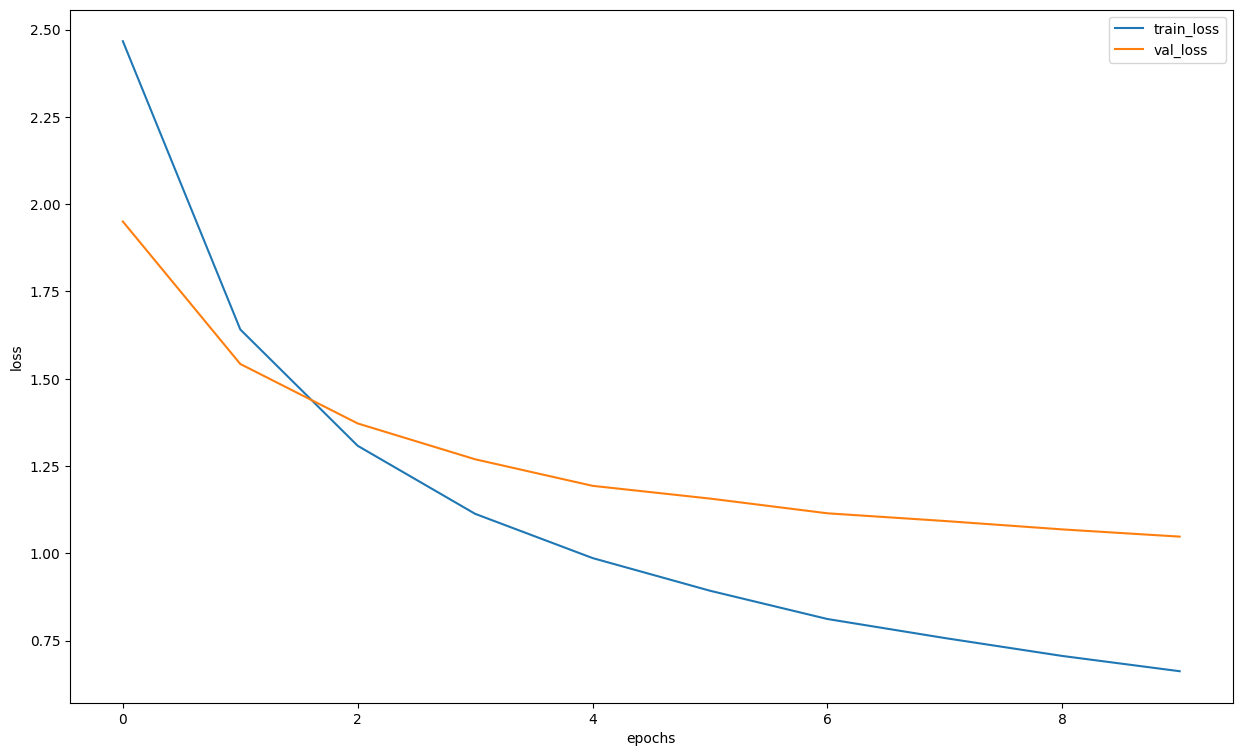

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_inception3, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_inception3, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.7


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_inception3, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('Inception_baseline.csv', index=False)

### Inception (Feature Extractor)

In [ ]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.Mixed_7b.parameters():
    param.requires_grad = True

for param in model.Mixed_7c.parameters():
    param.requires_grad = True

In [ ]:
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, n_classes)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,  n_classes)

In [ ]:
model_inception_extractor = model.to(DEVICE)

In [ ]:
RESCALE_SIZE = 299

In [ ]:
history = train(train_dataset, val_dataset, model=model_inception_extractor, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7080677989994889


epoch:  10%|█         | 1/10 [02:35<23:17, 155.29s/it]


Epoch 001 train_loss: 0.7081     val_loss 0.3926 train_acc 0.8291 val_acc 0.8963
loss 0.35776596335409794


epoch:  20%|██        | 2/10 [05:09<20:35, 154.38s/it]


Epoch 002 train_loss: 0.3578     val_loss 0.4021 train_acc 0.9072 val_acc 0.8985
loss 0.20368866933482063


epoch:  30%|███       | 3/10 [07:42<17:58, 154.00s/it]


Epoch 003 train_loss: 0.2037     val_loss 0.3739 train_acc 0.9460 val_acc 0.9136
loss 0.09629234922413264


epoch:  40%|████      | 4/10 [10:17<15:26, 154.41s/it]


Epoch 004 train_loss: 0.0963     val_loss 0.3617 train_acc 0.9732 val_acc 0.9282
loss 0.09966392608571716


epoch:  50%|█████     | 5/10 [12:51<12:50, 154.15s/it]


Epoch 005 train_loss: 0.0997     val_loss 0.4047 train_acc 0.9725 val_acc 0.9205
loss 0.06235943830683664


epoch:  60%|██████    | 6/10 [15:25<10:16, 154.06s/it]


Epoch 006 train_loss: 0.0624     val_loss 0.3814 train_acc 0.9826 val_acc 0.9293
loss 0.06114420570403241


epoch:  70%|███████   | 7/10 [17:58<07:41, 153.87s/it]


Epoch 007 train_loss: 0.0611     val_loss 0.3903 train_acc 0.9841 val_acc 0.9178
loss 0.06829166758330746


epoch:  80%|████████  | 8/10 [20:33<05:08, 154.26s/it]


Epoch 008 train_loss: 0.0683     val_loss 0.5031 train_acc 0.9815 val_acc 0.9106
loss 0.07399781228926647


epoch:  90%|█████████ | 9/10 [23:07<02:34, 154.00s/it]


Epoch 009 train_loss: 0.0740     val_loss 0.6560 train_acc 0.9820 val_acc 0.8900
loss 0.04908849483647029


epoch: 100%|██████████| 10/10 [25:40<00:00, 154.09s/it]


Epoch 010 train_loss: 0.0491     val_loss 0.3898 train_acc 0.9864 val_acc 0.9375


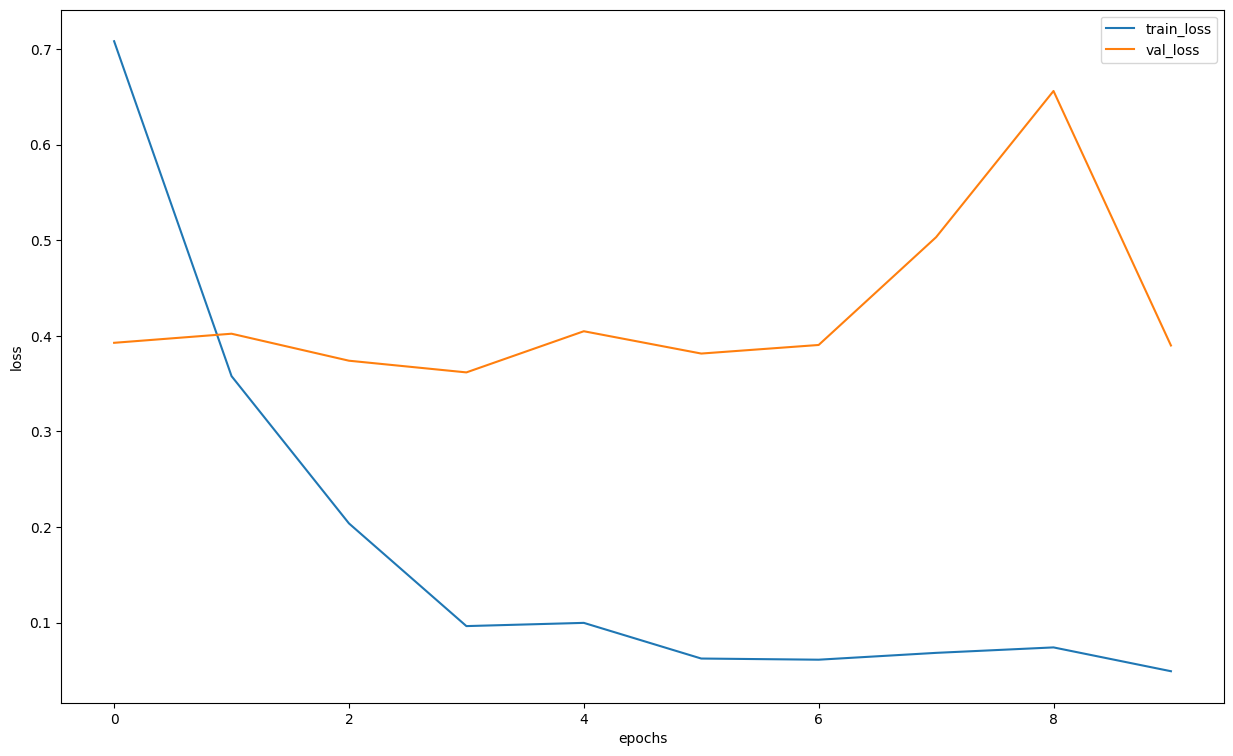

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_inception_extractor, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_inception_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.9500000000000001


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_inception_extractor, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('Inception_extractor_baseline.csv', index=False)

### ResNet50

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
in_features = model.fc.in_features
model.fc =nn.Linear(in_features,n_classes)
model_resnet = model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=10, batch_size=16)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.9060153673694304


epoch:  10%|█         | 1/10 [03:41<33:14, 221.65s/it]


Epoch 001 train_loss: 1.9060     val_loss 1.3481 train_acc 0.4838 val_acc 0.6551
loss 3.6199659800801327


epoch:  20%|██        | 2/10 [07:17<29:07, 218.48s/it]


Epoch 002 train_loss: 3.6200     val_loss 3.1169 train_acc 0.1074 val_acc 0.1074
loss 3.117924608647561


epoch:  30%|███       | 3/10 [10:55<25:25, 217.96s/it]


Epoch 003 train_loss: 3.1179     val_loss 3.1231 train_acc 0.1073 val_acc 0.1074
loss 3.1111027162783813


epoch:  40%|████      | 4/10 [14:31<21:44, 217.41s/it]


Epoch 004 train_loss: 3.1111     val_loss 3.1160 train_acc 0.1064 val_acc 0.1074
loss 3.0715742299219433


epoch:  50%|█████     | 5/10 [18:08<18:05, 217.13s/it]


Epoch 005 train_loss: 3.0716     val_loss 3.0032 train_acc 0.1082 val_acc 0.1141
loss 2.881221356092118


epoch:  60%|██████    | 6/10 [21:44<14:26, 216.73s/it]


Epoch 006 train_loss: 2.8812     val_loss 2.7740 train_acc 0.1559 val_acc 0.1947
loss 2.3538239106865277


epoch:  70%|███████   | 7/10 [25:22<10:51, 217.17s/it]


Epoch 007 train_loss: 2.3538     val_loss 1.9932 train_acc 0.3377 val_acc 0.4725
loss 1.646628390763913


epoch:  80%|████████  | 8/10 [28:58<07:13, 216.88s/it]


Epoch 008 train_loss: 1.6466     val_loss 1.4495 train_acc 0.5535 val_acc 0.6089
loss 1.185458566263319


epoch:  90%|█████████ | 9/10 [32:35<03:36, 216.93s/it]


Epoch 009 train_loss: 1.1855     val_loss 1.1112 train_acc 0.6737 val_acc 0.7056
loss 0.906580576977006


epoch: 100%|██████████| 10/10 [36:13<00:00, 217.35s/it]


Epoch 010 train_loss: 0.9066     val_loss 0.9257 train_acc 0.7510 val_acc 0.7570


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

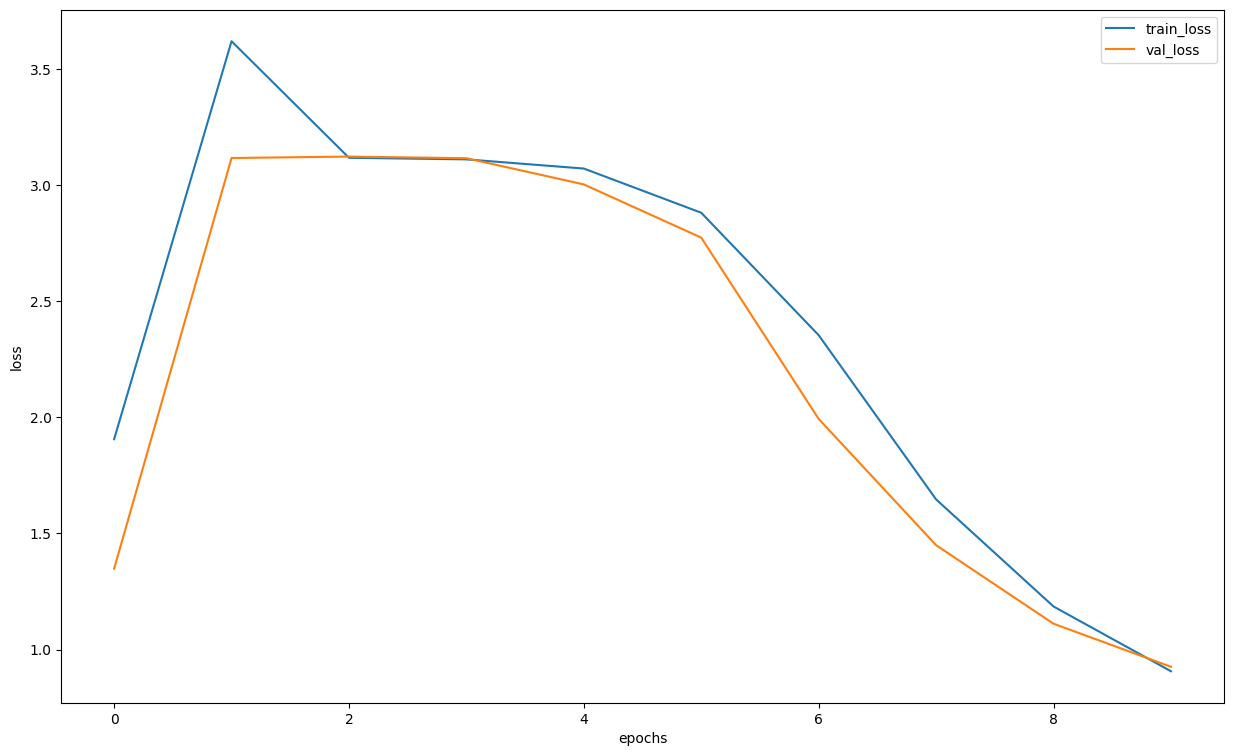

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_resnet, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.7


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('Resnet_baseline.csv', index=False)

### ResNet50 (Feature Extractor)

In [ ]:
model = models.resnet50(pretrained=True)
model.aux_logits=False
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
in_features = model.fc.in_features
model.fc =nn.Linear(in_features,n_classes)
model_resnet_extractor = model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_resnet_extractor, epochs=10, batch_size=16)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8576220158361555


epoch:  10%|█         | 1/10 [02:51<25:47, 171.99s/it]


Epoch 001 train_loss: 0.8576     val_loss 0.6010 train_acc 0.7847 val_acc 0.8468
loss 0.4301356016195225


epoch:  20%|██        | 2/10 [05:41<22:44, 170.57s/it]


Epoch 002 train_loss: 0.4301     val_loss 0.3770 train_acc 0.8899 val_acc 0.9213
loss 0.23145501579679192


epoch:  30%|███       | 3/10 [08:32<19:54, 170.64s/it]


Epoch 003 train_loss: 0.2315     val_loss 0.3352 train_acc 0.9380 val_acc 0.9243
loss 0.1513346114649105


epoch:  40%|████      | 4/10 [11:21<17:00, 170.11s/it]


Epoch 004 train_loss: 0.1513     val_loss 0.2420 train_acc 0.9606 val_acc 0.9448
loss 0.13355870464590144


epoch:  50%|█████     | 5/10 [14:12<14:11, 170.33s/it]


Epoch 005 train_loss: 0.1336     val_loss 0.3217 train_acc 0.9649 val_acc 0.9316
loss 0.10700145539817671


epoch:  60%|██████    | 6/10 [17:01<11:20, 170.08s/it]


Epoch 006 train_loss: 0.1070     val_loss 0.2602 train_acc 0.9728 val_acc 0.9408
loss 0.08341339721123711


epoch:  70%|███████   | 7/10 [19:50<08:29, 169.75s/it]


Epoch 007 train_loss: 0.0834     val_loss 0.3361 train_acc 0.9764 val_acc 0.9282
loss 0.04050473112286791


epoch:  80%|████████  | 8/10 [22:40<05:39, 169.55s/it]


Epoch 008 train_loss: 0.0405     val_loss 0.2664 train_acc 0.9894 val_acc 0.9522
loss 0.04928890080898303


epoch:  90%|█████████ | 9/10 [25:29<02:49, 169.58s/it]


Epoch 009 train_loss: 0.0493     val_loss 0.2243 train_acc 0.9872 val_acc 0.9585
loss 0.03540854354041472


epoch: 100%|██████████| 10/10 [28:22<00:00, 170.28s/it]


Epoch 010 train_loss: 0.0354     val_loss 0.2689 train_acc 0.9907 val_acc 0.9545


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

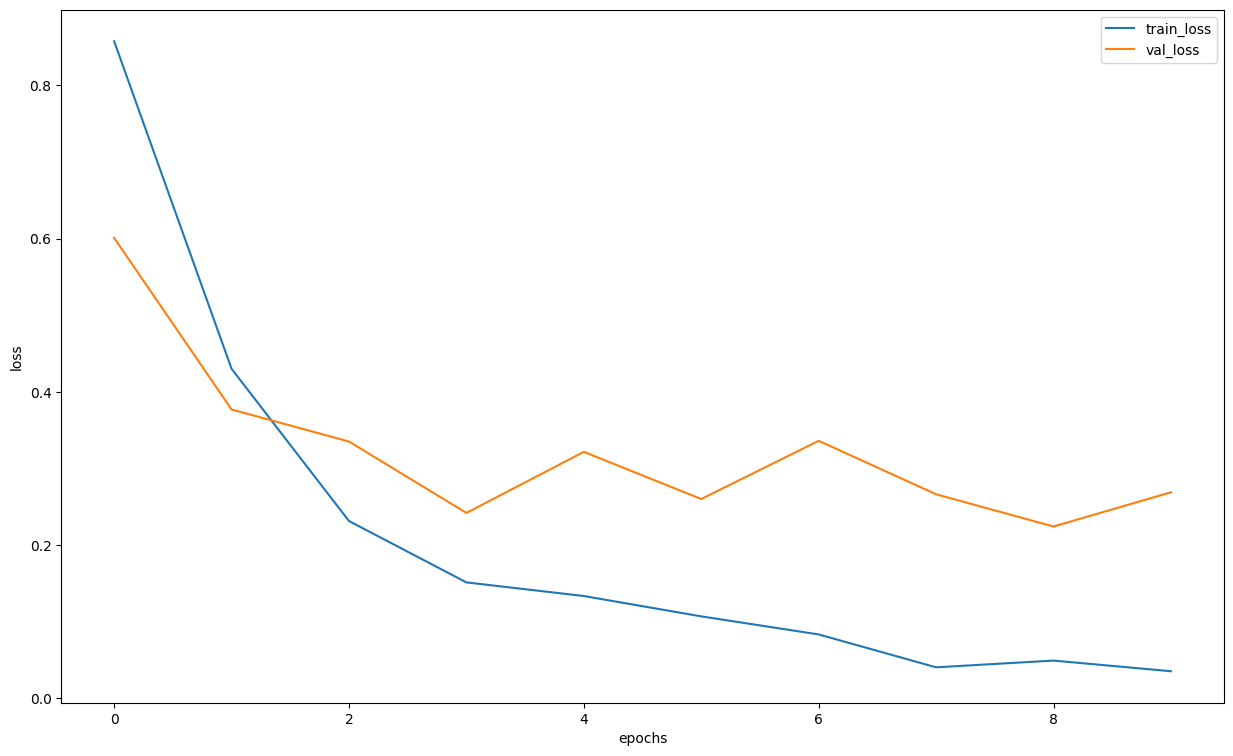

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet_extractor, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_resnet_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.9500000000000001


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet_extractor, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('Resnet_extractor_baseline.csv', index=False)

### Result:

The best result was Inception_v3 = 0.96599 and ResNet50 = 0.97768